# GenVeg Main Script
GenVeg is a generalized vegetation growth model that simulates growth due to
photosynthesis as well as processes that control vegetation distribution such
as mortality, senescence, dispersal, and colonization. The model utilizes a 
mixture of existing and new landlab components to setup the model, simulates
relevant vegetation community dynamics with the local environment, and analyzes
results of the simulation. 

## Main model control set up
### Import components

In [1]:
import numpy as np, pandas as pd
import os, tempfile
from pathlib import Path
from datetime import date
from matplotlib.pyplot import title, show, figure, plot, subplot, xlabel, ylabel
from landlab import RasterModelGrid, imshow_grid, load_params
from landlab.data_record import DataRecord
from landlab.components.genveg import VegParams, GenVeg
from landlab.io.netcdf import write_netcdf, read_netcdf
from scipy.io import netcdf_file

### Define time controls

In [2]:
sim_start_date = np.datetime64('2010-01-01')
tot_sim_len_y = 30
veg_time_step_d = 1
env_time_step_d = 1
dt=np.timedelta64(min([veg_time_step_d,env_time_step_d]),'D')
run_length_d=365

### Define filenames for input files
##### *Note should be located in same folder as this .ipynb

In [3]:
VegInputFile = 'GenVeg_Example_Simulation.xlsx'

### Read in parameter and data input files
Identify model processes to be included so all required parameters are defined and calculated

In [4]:
inp_file=Path(VegInputFile).absolute()
VegParams(fpath=inp_file,processes=['plantsize','dispersal'])
#VegParams(processes=['plantsize','dispersal','colonization','storage','mortality'])
vegparams=load_params('veg_params.yml')
print(vegparams)


{'Corn': {'dispersal_params': {'carb_cost_dispersal': 0.0, 'max_dist_dispersal': 4.0, 'min_size_dispersal': 0.5, 'reproduction_start': 180.0}, 'duration_params': {'growing_season_end': 243, 'growing_season_start': 121, 'senescence_start': 228}, 'grow_params': {'glucose_requirement': {'leaf': 1.513, 'reproductive': 1.414, 'root': 1.444, 'stem': 1.463, 'storage': 1.415}, 'growth_max_biomass': 61, 'growth_min_biomass': 0.61, 'k_light_extinct': 0.51, 'light_half_sat': 100, 'p_max': 0.0372, 'plant_part_max': {'leaf': 25, 'reproductive': 30, 'root': 6, 'stem': 30, 'storage': 5}, 'plant_part_min': {'leaf': 0.1, 'reproductive': 0, 'root': 0.01, 'stem': 0.5, 'storage': 0}, 'respiration_coefficient': {'leaf': 0.015, 'reproductive': 0.01, 'root': 0.015, 'stem': 0.03, 'storage': 0.01}, 'root_to_leaf_coeffs': [0.031, 0.951, 0], 'root_to_stem_coeffs': [-0.107, 1.098, 0.0216], 'total_max_biomass': 96, 'total_min_biomass': 0.61}, 'plant_factors': {'angio_gymno': 'angiosperm', 'duration': 'annual', 'gr

### Set up model grid using landlab RasterModelGrid functions

- Create the model grid
- Initialize live vegetation biomass and plant functional type
- Initialize the air temperature driver across the grid

##### **Note variable names should be consistent with landlab standards

In [5]:
#Create grid 10x10 node grid with 2 m node spacing and xy of origin in lat long roughly corresponding to Island Beach State Park
pg = RasterModelGrid((6, 6), 2.0, xy_of_reference=(-74.08,39.79))
pg.axis_units = ('m', 'm')

meantemp=[-0.20,  0.87,  4.40,  9.81,  15.36,  20.64,  23.86,  23.33, 19.95, 13.80,  7.85,  2.77, 11.93]
dailyTotGlobRad=[22.3, 26.8, 32.2, 37.1, 40.0, 40.9, 40.4, 38.2, 33.9, 28.5, 23.3, 21.0]
NJ_avg_par=[36.38, 52.39, 70.82, 92.88, 105.00, 116.38, 118.75, 103.21, 84.41, 59.15, 42.18, 31.98, 76.22]                
#Initialize with a random mean air temperture 
_ = pg.add_field('air__temperature_C', meantemp[0]*np.ones(pg.number_of_cells), at='cell', units='C' )
_ = pg.add_field('radiation__par_tot', NJ_avg_par[0]*np.ones(pg.number_of_cells), at='cell', units='W/m^2')


Now we initialize plants. We can do this in multiple ways. Here we are going to seed two species in a grid with 1/2 occupied by Corn, 1/2 by wheat, at single and double planting densities, respectively

In [6]:
#Initialize plant functional type as burial tolerant stabilizer or dune builder and randomly place on grid
plant_species_init=['Corn','Wheat']
plant_list_1=['Corn','null','null','null']
plant_list_2=['null','null','Wheat','null']
plant_list_3=['Corn','Corn','null','null']
plant_list_4=['null','null','Wheat','Wheat']
plant_lists=[plant_list_1,plant_list_2,plant_list_3, plant_list_4]
plants_on_grid=[]
length_field_part=pg.number_of_cells/4
for plant_list in plant_lists:
    for i in range(int(length_field_part)):
        #if plants_on_grid.isempty
        plants_on_grid.append(plant_list)

_ = pg.add_field('vegetation__plant_species',plants_on_grid, at='cell', clobber=True)

#occupied_ids=np.where(pg.at_cell['vegetation__plant_species']=='BTS')

pidval=0
plants=pd.DataFrame(columns=['pid','species','cell_index'])
for cell in range(pg.number_of_cells):
    cell_index=cell
    cell_plants=pg['cell']['vegetation__plant_species'][cell]
    for plant in cell_plants:
        species=plant
        newrow=[pidval,species,cell_index]
        plants.loc[pidval]=newrow
        pidval += 1

pid=plants.pid.loc[plants['species']=='BTS'].to_numpy(int)
total_biomass=np.random.rand(pid.shape[0])
total_biomass2=np.random.rand(6)

species_set=np.vstack((pid,total_biomass))
species_set2=np.vstack((total_biomass2,total_biomass2))
species_set=np.transpose(species_set)
species_set2=np.transpose(species_set2)
biomass=np.concatenate((species_set,species_set2), axis=0)
print(biomass)
biomass=np.transpose(biomass)
print(biomass)

### Plot grid with plant distribution and initial biomass

Use RasterModelGrid plot functions to visualize initial model grid

#### Vegetation type 
- 0=Bare
- 1=Annual
- 2=Herbaceous Perennial 
- 3=Woody Perennial

### Define model time variables
Determine basic model timestep and counter for model loop

sim_end = date(sim_start_date.year+tot_sim_len_y,sim_start_date.month,sim_start_date.day)
dt = min([veg_time_step_d,env_time_step_d])
#data['dt']=dt
day_freq = str(dt)+'D'
date_counter = pd.date_range(start=sim_start_date,end=sim_end,freq=day_freq).strftime('%Y-%m-%d').tolist()
step_counter=range(len(date_counter))
model_counter=tuple(zip(step_counter,date_counter))

Initialize crops PlantGrowth class with veg_params from Excel file

In [7]:
croprun=GenVeg(pg,dt,sim_start_date,vegparams)

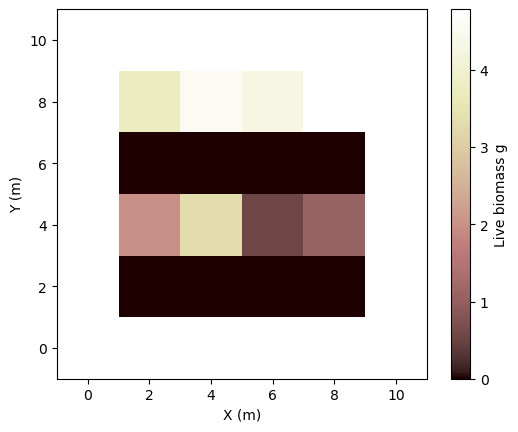

In [8]:
imshow_grid(pg, 'vegetation__total_biomass', at='cell', colorbar_label='Live biomass g')

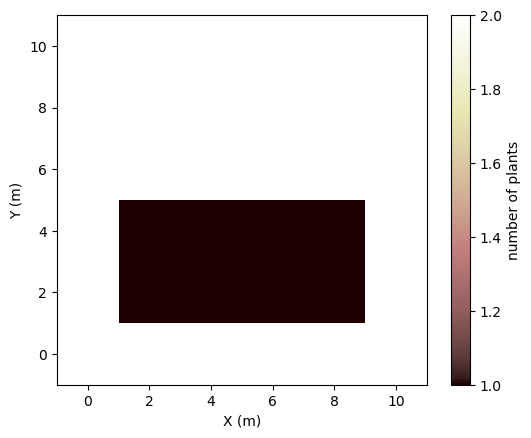

In [9]:
imshow_grid(pg, 'vegetation__n_plants', at='cell', colorbar_label='number of plants')

## Main model loop script
This is the main model loop that controls the simulation that
- Advances model time 
- Updates environmental variables
- Simulates changes to vegetation communities
- Stores outputs

In [10]:
#This runs through fine for day 1 of growing season. We need to decide how to track current day
temp_dir = tempfile.mkdtemp()
os.chdir(temp_dir)
j=-1
for i in range(run_length_d):
    #update temp attribute on grid
    if (i/30).is_integer():
        pg.at_cell['air__temperature_C']= meantemp[j+1]*np.ones(pg.number_of_cells)
        pg.at_cell['radiation__par_tot']= NJ_avg_par[j+1]*np.ones(pg.number_of_cells)
        j+=1
    #update solar radiation on grid
    croprun.run_one_step()
    
    if (i/7).is_integer():
        croprun.save_output()
        croprun.get_plant_output('Corn')
        write_netcdf("crop.nc",pg, format="NETCDF3_64BIT",append=True, time=(croprun.current_day-croprun.start_date).astype(float)-1, names=['vegetation__total_biomass', 'vegetation__n_plants'])

          #if this is a save timestep, save grid object to netcdf
    #create record method in croprun that uses datarecord to save PlantGrowth object and grid at time
    #if i in savetime:
    #    croprun.record()

0
Corn
0
Wheat
1
Corn
1
Wheat
2
Corn
2
Wheat
3
Corn
3
Wheat
4
Corn
4
Wheat
5
Corn
5
Wheat
6
Corn
6
Wheat
7
Corn
7
Wheat
8
Corn
8
Wheat
9
Corn
9
Wheat
10
Corn
10
Wheat
11
Corn
11
Wheat
12
Corn
12
Wheat
13
Corn
13
Wheat
14
Corn
14
Wheat
15
Corn
15
Wheat
16
Corn
16
Wheat
17
Corn
17
Wheat
18
Corn
18
Wheat
19
Corn
19
Wheat
20
Corn
20
Wheat
21
Corn
21
Wheat
22
Corn
22
Wheat
23
Corn
23
Wheat
24
Corn
24
Wheat
25
Corn
25
Wheat
26
Corn
26
Wheat
27
Corn
27
Wheat
28
Corn
28
Wheat
29
Corn
29
Wheat
30
Corn
30
Wheat
31
Corn
31
Wheat
32
Corn
32
Wheat
33
Corn
33
Wheat
34
Corn
34
Wheat
35
Corn
35
Wheat
36
Corn
36
Wheat
37
Corn
37
Wheat
38
Corn
38
Wheat
39
Corn
39
Wheat
40
Corn
40
Wheat
41
Corn
41
Wheat
42
Corn
42
Wheat
43
Corn
43
Wheat
44
Corn
44
Wheat
45
Corn
45
Wheat
46
Corn
46
Wheat
47
Corn
47
Wheat
48
Corn
48
Wheat
49
Corn
49
Wheat
50
Corn
50
Wheat
51
Corn
51
Wheat
52
Corn
52
Wheat
53
Corn
53
Wheat
54
Corn
54
Wheat
55
Corn
55
Wheat
56
Corn
56
Wheat
57
Corn
57
Wheat
58
Corn
58
Wheat
59
Corn
59
Wheat


In [11]:
print(vegparams)

{'Corn': {'dispersal_params': {'carb_cost_dispersal': 0.0, 'max_dist_dispersal': 4.0, 'min_size_dispersal': 0.5, 'reproduction_start': 180.0}, 'duration_params': {'growing_season_end': 243, 'growing_season_start': 121, 'senescence_start': 228}, 'grow_params': {'glucose_requirement': {'leaf': 1.513, 'reproductive': 1.414, 'root': 1.444, 'stem': 1.463, 'storage': 1.415}, 'growth_max_biomass': 61, 'growth_min_biomass': 0.61, 'k_light_extinct': 0.51, 'light_half_sat': 100, 'p_max': 0.0372, 'plant_part_max': {'leaf': 25, 'reproductive': 30, 'root': 6, 'stem': 30, 'storage': 5}, 'plant_part_min': {'leaf': 0.1, 'reproductive': 0, 'root': 0.01, 'stem': 0.5, 'storage': 0}, 'respiration_coefficient': {'leaf': 0.015, 'reproductive': 0.01, 'root': 0.015, 'stem': 0.03, 'storage': 0.01}, 'root_to_leaf_coeffs': [0.031, 0.951, 0], 'root_to_stem_coeffs': [-0.107, 1.098, 0.0216], 'total_max_biomass': 96, 'total_min_biomass': 0.61}, 'plant_factors': {'angio_gymno': 'angiosperm', 'duration': 'annual', 'gr

In [12]:
output=croprun.get_plant_output()

grid = netcdf_file('crop.nc', 'r')
print(grid.__dict__)

timegrid=grid.variables['t']
timegrid[:]

vegbio=grid.variables['vegetation__total_biomass']
vegbio.shape

vegbio[10,:,:]

In [13]:
output.index.unique(level=2)

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype='int64', name='item_id')

In [14]:
output.loc[:, 'Wheat',6] #timestep,species,plant number in []

,grid_element,element_id,vegetation__root_biomass,vegetation__leaf_biomass,vegetation__stem_biomass,vegetation__storage_biomass,vegetation__repro_biomass,vegetation__plant_age
time,,,,,,,,
0.0,cell,13.0,2.647041,0.000000,0.000000,0.536462,0.000000,0.0
1.0,cell,13.0,2.647041,0.000000,0.000000,0.536462,0.000000,NaN
8.0,cell,13.0,2.609027,0.000000,0.000000,0.536462,0.000000,NaN
15.0,cell,13.0,2.571493,0.000000,0.000000,0.536462,0.000000,NaN
22.0,cell,13.0,2.534432,0.000000,0.000000,0.536462,0.000000,NaN
29.0,cell,13.0,2.497839,0.000000,0.000000,0.536462,0.000000,NaN
36.0,cell,13.0,2.459337,0.000000,0.000000,0.536462,0.000000,NaN
43.0,cell,13.0,2.420962,0.000000,0.000000,0.536462,0.000000,NaN
50.0,cell,13.0,2.383108,0.000000,0.000000,0.536462,0.000000,NaN


output.loc[21.0]

In [15]:
biomass = output["vegetation__root_biomass"].values
display(biomass)


array([ 0.        ,  0.        ,  0.        , ...,  1.25329822,
        1.303936  ,  1.25755906])

grid.close()